In [1]:
# This file is a simple implementation of the 
from keras.models import Sequential
from keras.layers import LSTM
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
model = Sequential()
eurusd = pd.read_csv(r"C:\Users\edgil\Documents\Masters\dissertation\code64\data_set\eurusd_train_normed.csv")
eurusd = eurusd.replace(np.nan, 0)

Using TensorFlow backend.


In [41]:
from keras.models import Model # Dense
model.add(Dense(units=2, activation='relu', input_dim=2))
model.add(Dense(units=1, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
x_train = np.array([[1,1],[1,0],[0,1],[0,0]])
y_train = np.array([0,1,0,0])
# x_train and y_train are Numpy arrays --just like in the Scikit-Learn API.
model.fit(x_train, y_train, epochs=5, batch_size=32)

In [2]:
# set up the training data for the model
# we must normalise the inputs so they can pick up the correct values
data = [[[(i+j)/100]for i in range(0,5)] for j in range(0,100)]
target = [[(i+5)/100] for i in range(0,100)]
npData = np.array(data, dtype = float)
npTarget = np.array(target, dtype = float)
npData.shape
x_train, x_test, y_train, y_test = train_test_split(npData,npTarget,test_size = 0.2, random_state = 4)
# data stored as data[row_obversation][first_col_data][value_of_col]

In [61]:
# TODO Friday-> Tomorrow
# Get LSTM model working with your train,test data first
# get it learning and giving output. Then look to refine the model. think about the target, how will we create probability distributions? 
# get the EURUSD data
#npData.shape
# Data needs to be reshaped into 3D tensor
sample_data = eurusd.iloc[:100,:].values
target = np.array([[i] for i in range(0,96)])
sample_data.shape
target.shape
# reshape sems to add another list around every observation
sample_data = sample_data.reshape(sample_data.shape[0], 1, sample_data.shape[1])
# this creates your dataset with the lookback periods it needs to use.

import numpy as np
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back+1):
    a = dataset[i:(i+look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back - 1, :])
  return np.array(dataX), np.array(dataY)

sample_data = create_dataset(sample_data,5)[0]



In [62]:
sample_data = sample_data.reshape(sample_data.shape[0], sample_data.shape[1], sample_data.shape[3])
sample_data[0]

array([[-6.45781570e-01,  0.00000000e+00, -6.45683787e-01,
        -6.45484613e-01, -6.44697771e-01, -6.43812163e-01,
        -2.19187968e-02, -3.70896043e-02, -6.95595882e-02,
        -9.29097071e-02, -6.43416237e-01, -6.38447391e-01,
        -6.12951492e-01, -5.79183418e-01, -1.01655702e-01,
        -1.77461191e-01, -3.49814022e-01, -4.70413261e-01,
        -6.32852631e-01, -5.98253516e-01, -4.48348777e-01,
        -3.17243415e-01, -2.31456480e-01, -4.09247164e-01,
        -7.43890794e-01, -9.13950762e-01, -7.54163264e-02,
        -3.75057763e-01, -7.45249847e-01, -9.53787446e-02,
        -4.85096588e-01, -9.54745026e-01,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [-6.45781570e-01, -5.86630195e-03, -6.45683787e-01,
        -6.45484613e-01, -6.44697771e-01, -6.43812163e-01,
        -2.19187968e-02, -3.70896043e-02, -6.95595882e-02,
        -9.29097071e-02, -6.43416237e-01, -6.38447391e-01,
        -6.12951492e-01, -5.79183418e-01, -1.01655702e-01,
        -1.77

In [63]:
# this code sets up the LSTM model.
'''
Original
model = Sequential()
model.add(LSTM((1),batch_input_shape = (None,5,1), return_sequences = True))
model.add(LSTM((1), return_sequences = False))
model.compile(loss = "mean_absolute_error", optimizer="adam", metrics = ['accuracy'])
model.summary()
'''
# need to try understand the input shapes and what is required of it.
# look at tutorials where they use this data
# Friday:GOAL have the LSTM working with your input (and variable data set)
# BONUS GOAL: simulate trendy and mean reverty data.
# batch_input_shape (no_obversations,timelookback, features)
model = Sequential()
model.add(LSTM(1,batch_input_shape = (None,5,35), return_sequences = True))
model.add(LSTM(1, return_sequences = False))
model.compile(loss = "mean_absolute_error", optimizer="adam", metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 5, 1)              148       
_________________________________________________________________
lstm_10 (LSTM)               (None, 1)                 12        
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________


In [64]:
# model training
'''
history = model.fit(x_train,y_train, epochs=100,validation_data=(x_test,y_test))
results = model.predict(x_test)
'''

history = model.fit(sample_data,target, epochs=5,validation_data=(sample_data,target))
results = model.predict(sample_data)

Train on 96 samples, validate on 96 samples
Epoch 1/5


32/96 [=========>....................] - ETA: 2s - loss: 48.7737 - acc: 0.0000e+00

96/96 [==============================] - 2s 17ms/step - loss: 47.5222 - acc: 0.0104 - val_loss: 47.5143 - val_acc: 0.0104


Epoch 2/5


32/96 [=========>....................] - ETA: 0s - loss: 51.7016 - acc: 0.0312

96/96 [==============================] - 0s 334us/step - loss: 47.5105 - acc: 0.0104 - val_loss: 47.5034 - val_acc: 0.0104


Epoch 3/5
32/96 [=========>....................] - ETA: 0s - loss: 47.2239 - acc: 0.0312

96/96 [==============================] - 0s 300us/step - loss: 47.4999 - acc: 0.0104 - val_loss: 47.4932 - val_acc: 0.0104


Epoch 4/5
32/96 [=========>....................] - ETA: 0s - loss: 51.7534 - acc: 0.0000e+00

96/96 [==============================] - 0s 353us/step - loss: 47.4902 - acc: 0.0104 - val_loss: 47.4836 - val_acc: 0.0104


Epoch 5/5
32/96 [=========>....................] - ETA: 0s - loss: 38.4378 - acc: 0.0000e+00

96/96 [==============================] - 0s 315us/step - loss: 47.4806 - acc: 0.0104 - val_loss: 47.4742 - val_acc: 0.0104


In [34]:
# plot results
import matplotlib.pyplot as plt
plt.scatter(range(20), results, c = "r")
plt.scatter(range(20), y_test, c = "g")
plt.show()

ValueError: x and y must be the same size

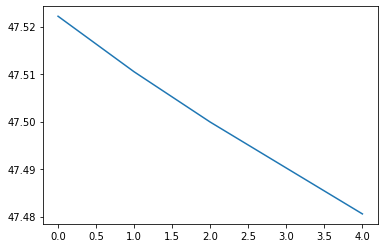

In [65]:
# lets see the history of the error update.
plt.plot(history.history['loss'])
plt.show()
